<a href="https://colab.research.google.com/github/Torikul385/GAN/blob/main/cyclegan_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import threading
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import keras
from keras import layers

from google.colab import drive
import os

import tensorflow_addons as tfa
import tensorflow_datasets as tfds


In [ ]:
# Load the horse-zebra dataset using tensorflow-datasets.
ds, _ = tfds.load("cycle_gan/horse2zebra", with_info=True, as_supervised=True)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/1067 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0.incompletePKGHU1/cycle_gan-trainA.tfrecord*...…

Generating trainB examples...:   0%|          | 0/1334 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0.incompletePKGHU1/cycle_gan-trainB.tfrecord*...…

Generating testA examples...:   0%|          | 0/120 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0.incompletePKGHU1/cycle_gan-testA.tfrecord*...:…

Generating testB examples...:   0%|          | 0/140 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0.incompletePKGHU1/cycle_gan-testB.tfrecord*...:…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0. Subsequent calls will reuse this data.


In [ ]:
ds

{'trainA': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'trainB': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'testA': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'testB': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

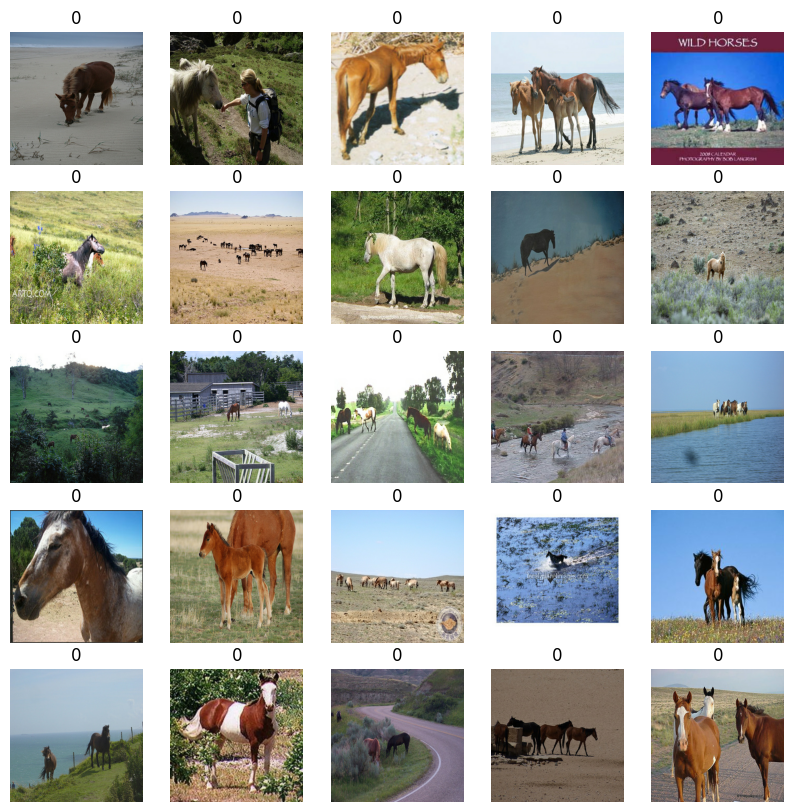

In [ ]:
sample = ds['trainA']

rows, cols = 5,5
plt.figure(figsize=(10,10))
i = 0
for img , label in sample.as_numpy_iterator():
  plt.subplot(rows, cols, i+1)
  plt.imshow(img)
  plt.title(f'{label}')
  plt.axis('off')

  i += 1
  if i>= rows*cols:
    break

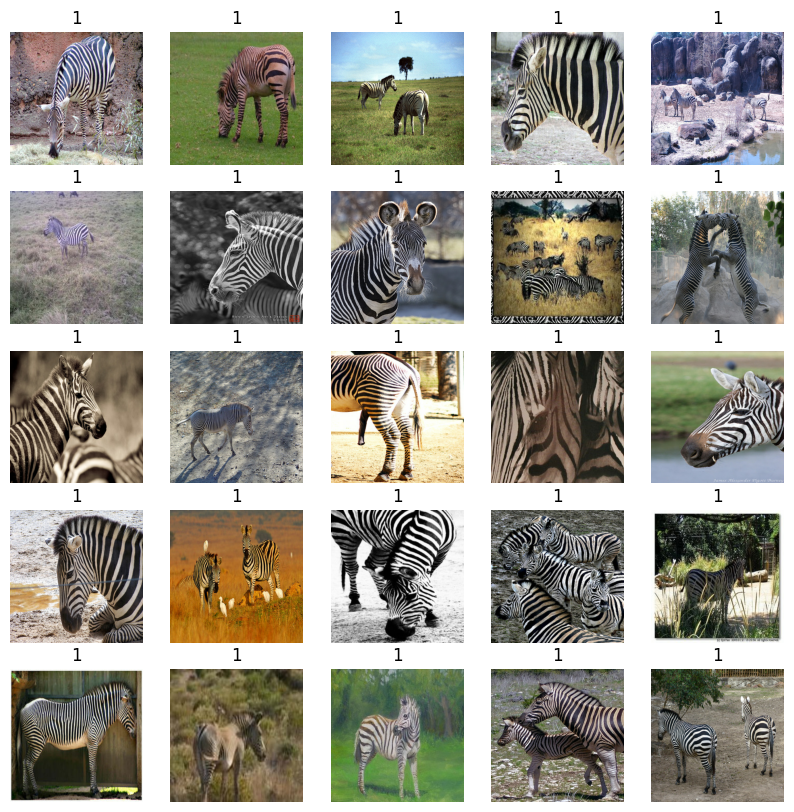

In [ ]:
sample = ds['trainB']

rows, cols = 5,5
plt.figure(figsize=(10,10))
i = 0
for img , label in sample.as_numpy_iterator():
  plt.subplot(rows, cols, i+1)
  plt.imshow(img)
  plt.title(f'{label}')
  plt.axis('off')

  i += 1
  if i>= rows*cols:
    break

In [ ]:
train_h= ds["trainA"]
train_z =  ds["trainB"]
test_h= ds["testA"]
test_z = ds["testB"]

In [ ]:
train_h

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
buffer_size = 256
batch_size = 1
autotune = tf.data.AUTOTUNE

In [ ]:

# Define the standard image size.
big_size = 286
# Size of the random crops to be used during training.
normal_size = 256

input_img_size = (256,256,3)


def normalize_img(img):
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Normalize the pixel values in the range [-1, 1]
    img = layers.Rescaling(scale= 1./127.5, offset=-1)(img)
    return img


def preprocess_train_image(img, label):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [big_size, big_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[normal_size, normal_size, 3])
    img = normalize_img(img)
    return img


def preprocess_test_image(img, label):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [normal_size, normal_size])
    img = normalize_img(img)
    return img


In [ ]:
# Apply the preprocessing operations to the training data

train_h = (
    train_h.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_z = (
    train_z.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

# Apply the preprocessing operations to the test data
test_h = (
    test_h.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_z = (
    test_z.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)


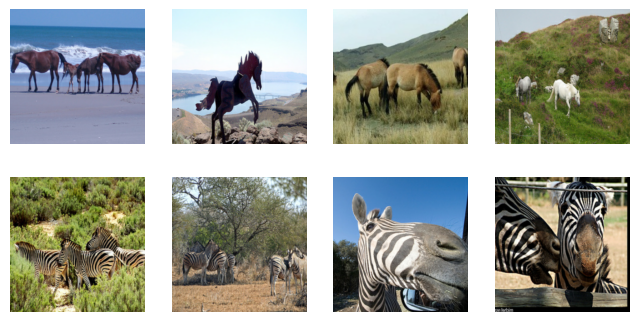

In [ ]:
plt.figure(figsize=(8,4))
for i, samples in enumerate(zip(train_h.take(4), train_z.take(4))):
    horse = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    zebra = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)

    plt.subplot(2,4,i+1)
    plt.imshow(horse)
    plt.axis('off')

    plt.subplot(2,4,4+i+1)
    plt.imshow(zebra)
    plt.axis('off')
plt.show()


In [ ]:
class ReflectionPadding2D(layers.Layer):

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")

In [ ]:
# This is how padding works!

x = tf.constant([[1,2,3], [4,5,6]])

tf.pad(x, [[1,0], [2,1]], 'CONSTANT')

<tf.Tensor: shape=(3, 6), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0],
       [0, 0, 1, 2, 3, 0],
       [0, 0, 4, 5, 6, 0]], dtype=int32)>

In [ ]:

# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x



In [ ]:
#Let's check how residual block work!

x = np.random.rand(1,32,32,3)
activation = layers.Activation('relu')
y  = residual_block(x, activation)

print(y.shape)

conv = layers.Conv2D(3, (3,3), strides=1, padding='valid')
y_conv = conv(y)
print(y.shape)

ref = ReflectionPadding2D()
y_ref = ref(x)
print(y_ref.shape)

ins_norm = tfa.layers.InstanceNormalization()
y_ins = ins_norm(x)
print(y_ins.shape)

(1, 32, 32, 3)
(1, 32, 32, 3)
(1, 34, 34, 3)
(1, 32, 32, 3)


In [ ]:

def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x




In [ ]:
#Let's check how downsample works!

x = np.random.rand(1,32,32,3)
down = downsample(x, 32, None)

down.shape

TensorShape([1, 16, 16, 32])

In [ ]:
def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


In [ ]:
#Let's check how downsample works!

x = np.random.rand(1,32,32,3)
up = upsample(x, 32, None)

up.shape

TensorShape([1, 64, 64, 32])

In [ ]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model


In [ ]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_Z = get_resnet_generator(name="generator_Z")
gen_H = get_resnet_generator(name="generator_H")

# Get the discriminators
disc_H = get_discriminator(name="discriminator_H")
disc_Z = get_discriminator(name="discriminator_Z")


In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_Z,
        generator_H,
        disc_H,
        disc_Z,
        lambda_cycle=10.0, #h -> gen_Z() -> z -> gen_H() -> h2 : (h,h2)
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_Z = generator_Z
        self.gen_H = generator_H
        self.disc_H = disc_H
        self.disc_Z = disc_Z
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_Z_optimizer,
        gen_H_optimizer,
        disc_H_optimizer,
        disc_Z_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_Z_optimizer = gen_Z_optimizer
        self.gen_H_optimizer = gen_H_optimizer
        self.disc_H_optimizer = disc_H_optimizer
        self.disc_Z_optimizer = disc_Z_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_h, real_z = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_z = self.gen_Z(real_h, training=True)
            # Zebra to fake horse -> y2x
            gen_h = self.gen_H(real_z, training=True)

            # Cycle (Horse to fake zebra to fake horse): h -> z -> h
            cycled_h = self.gen_H(fake_z, training=True)
            # Cycle (Zebra to fake horse to fake zebra) z -> h -> z
            cycled_z = self.gen_Z(gen_h, training=True)

            # Identity mapping
            same_h = self.gen_H(real_h, training=True)
            same_z = self.gen_Z(real_z, training=True)

            # Discriminator output
            disc_real_h = self.disc_H(real_h, training=True)
            disc_gen_h = self.disc_H(gen_h, training=True)

            disc_real_z = self.disc_Z(real_z, training=True)
            disc_fake_z = self.disc_Z(fake_z, training=True)

            # Generator adversarial loss
            gen_Z_loss = self.generator_loss_fn(disc_fake_z)
            gen_H_loss = self.generator_loss_fn(disc_gen_h)

            # Generator cycle loss
            cycle_loss_Z = self.cycle_loss_fn(real_z, cycled_z) * self.lambda_cycle
            cycle_loss_H = self.cycle_loss_fn(real_h, cycled_h) * self.lambda_cycle

            # Generator identity loss
            id_loss_Z = (
                self.identity_loss_fn(real_z, same_z)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_H = (
                self.identity_loss_fn(real_h, same_h)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_Z = gen_Z_loss + cycle_loss_Z + id_loss_Z
            total_loss_H = gen_H_loss + cycle_loss_H + id_loss_H

            # Discriminator loss
            disc_H_loss = self.discriminator_loss_fn(disc_real_h, disc_gen_h)
            disc_Z_loss = self.discriminator_loss_fn(disc_real_z, disc_fake_z)

        # Get the gradients for the generators
        grads_Z = tape.gradient(total_loss_Z, self.gen_Z.trainable_variables)
        grads_H = tape.gradient(total_loss_H, self.gen_H.trainable_variables)

        # Get the gradients for the discriminators
        disc_H_grads = tape.gradient(disc_H_loss, self.disc_H.trainable_variables)
        disc_Z_grads = tape.gradient(disc_Z_loss, self.disc_Z.trainable_variables)

        # Update the weights of the generators
        self.gen_Z_optimizer.apply_gradients(
            zip(grads_Z, self.gen_Z.trainable_variables)
        )
        self.gen_H_optimizer.apply_gradients(
            zip(grads_H, self.gen_H.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_H_optimizer.apply_gradients(
            zip(disc_H_grads, self.disc_H.trainable_variables)
        )
        self.disc_Z_optimizer.apply_gradients(
            zip(disc_Z_grads, self.disc_Z.trainable_variables)
        )

        return {
            "Z_loss": total_loss_Z,
            "H_loss": total_loss_H,
            "D_H_loss": disc_H_loss,
            "D_Z_loss": disc_Z_loss,
        }

    def get_config(self):
        # Get the base config from the parent class
        base_config = super(CycleGan, self).get_config()

        # Add custom config items specific to your model
        return dict(list(base_config.items()))


In [ ]:

adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
model = CycleGan(
    generator_Z=gen_Z, generator_H=gen_H, disc_H=disc_H, disc_Z=disc_Z
)

# Compile the model
model.compile(
    gen_Z_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_H_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_H_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Z_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_name = 'cyclegan_v3'
gdrive_path = '/content/drive/MyDrive/models'
def get_paths():
  new_folder = os.path.join(gdrive_path, folder_name)
  os.makedirs(new_folder, exist_ok=True)
  batch_path=os.path.join(new_folder, 'batch.weights.h5')
  epoch_path=os.path.join(new_folder, 'epoch.weights.h5')

  return (epoch_path, batch_path)

class CustomCallback(keras.callbacks.Callback):
  def __init__(self, epoch_path, batch_path):
    self.epoch_path = epoch_path
    self.batch_path = batch_path


  def save_weights(self, model, path):
    model.save_weights(path)
    print(f"\nweights are saved")

  def on_epoch_end(self, epoch, logs=None):
    save_thread = threading.Thread(target=self.save_weights, args=(self.model, self.epoch_path))
    save_thread.start()
  def on_batch_end(self, batch, logs=None):
    if (batch+1) % 501 == 0:
      save_thread = threading.Thread(target=self.save_weights, args=(self.model, self.batch_path))
      save_thread.start()


def train_model( train_ds,  epochs=2, callbacks=[]):
  epoch_path, batch_path = get_paths()
  callbacks.append(CustomCallback(epoch_path, batch_path))

  if os.path.exists(batch_path):
    model.load_weights(batch_path)
    print('weights are loaded')
  else:
    print("First time")

  history = model.fit(
      train_ds,
      epochs=epochs,

      callbacks=callbacks

  )
  return history

In [ ]:
#history = train_model(tf.data.Dataset.zip((train_h, train_z)),epochs=5 )


In [ ]:
model.load_weights(get_paths()[1])

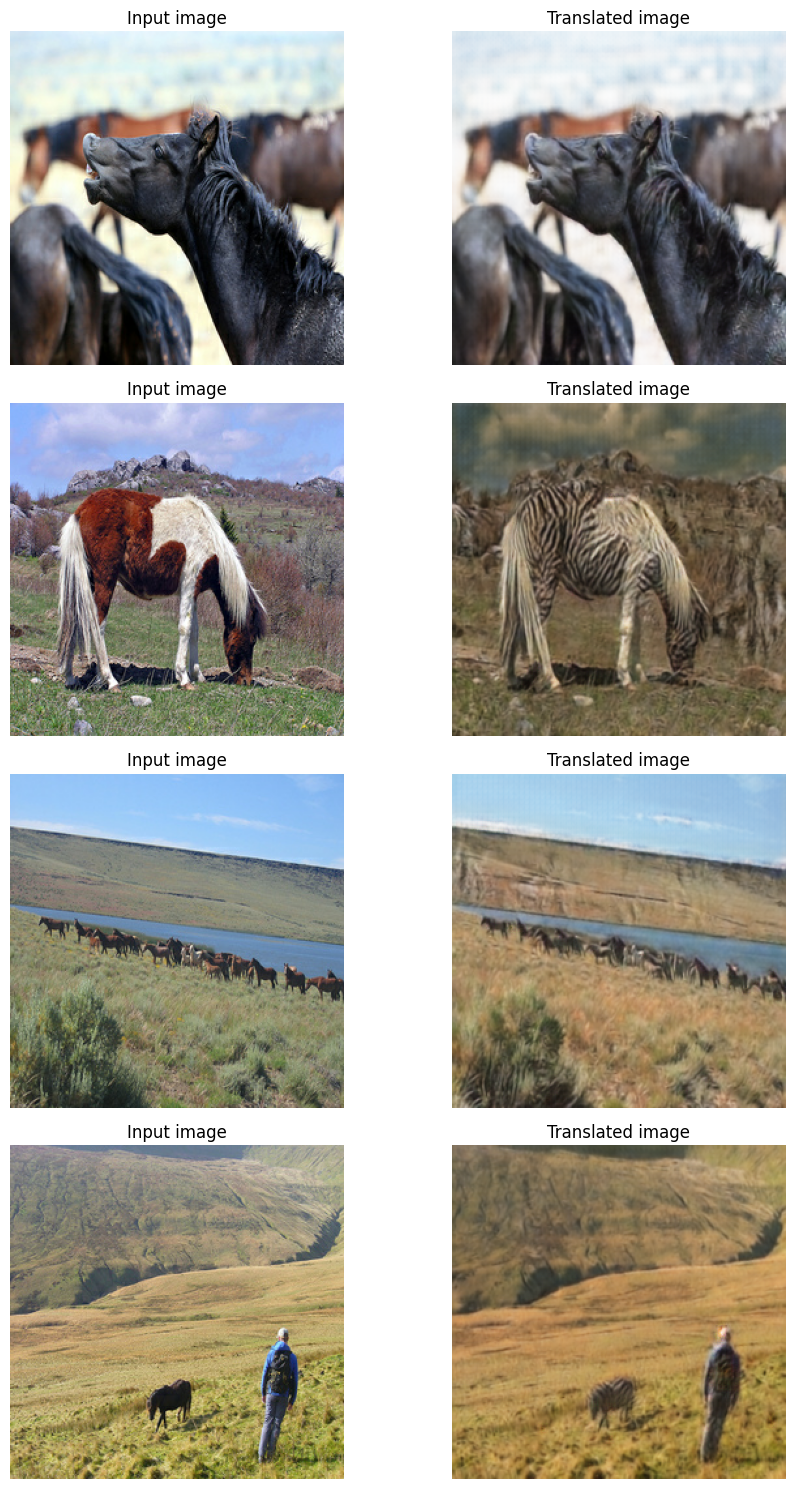

In [ ]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(test_h.take(4)):
    prediction = model.gen_Z(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.utils.array_to_img(prediction)

plt.tight_layout()
plt.show()